In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot  as plt

from xgboost import XGBRegressor
from xgboost import plot_importance




def plot_feature(booster, figsize):
    fig, ax = plt.subplots(1,1, figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info





sys.version_info(major=3, minor=8, micro=3, releaselevel='final', serial=0)

In [2]:
items = pd.read_csv('../input/items.csv')
shops = pd.read_csv('../input/shops.csv')
cats = pd.read_csv('../input/item_categories.csv')
train = pd.read_csv('../input/sales_train.csv')
test = pd.read_csv('../input/test.csv').set_index('ID')


<AxesSubplot:xlabel='item_price'>

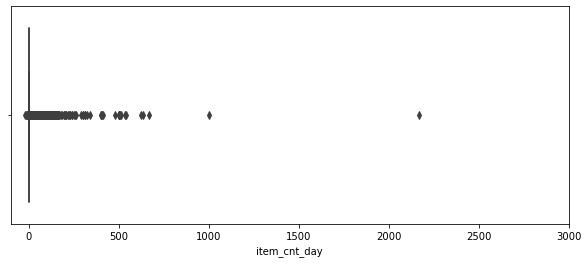

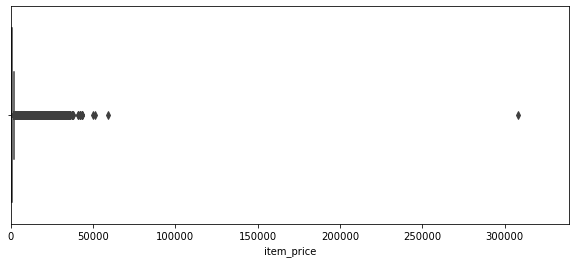

In [3]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)


In [4]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]


In [5]:
median = train[(train.shop_id==32) &(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [6]:
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] =57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58


In [7]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x:  x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])

cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id', 'type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [8]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))),len(list(set(test.item_id))),len(test)


(363, 5100, 214200)

In [9]:
set(test.item_id).intersection(set(train.item_id))

{8192,
 8193,
 16388,
 16395,
 16396,
 16398,
 8208,
 8214,
 8218,
 8219,
 30,
 31,
 32,
 33,
 8226,
 38,
 42,
 45,
 8237,
 8238,
 51,
 8244,
 53,
 16436,
 8247,
 57,
 8249,
 59,
 8251,
 62,
 64,
 8256,
 8257,
 67,
 8260,
 69,
 70,
 16450,
 72,
 16451,
 16459,
 76,
 16461,
 80,
 16469,
 88,
 16474,
 91,
 93,
 8287,
 8296,
 109,
 16494,
 8322,
 16515,
 8327,
 138,
 8330,
 8335,
 8336,
 149,
 16534,
 153,
 154,
 16541,
 16543,
 8352,
 8357,
 166,
 16549,
 8363,
 8364,
 8365,
 8366,
 16556,
 16560,
 180,
 8373,
 16567,
 16573,
 8386,
 16582,
 8391,
 16585,
 202,
 16586,
 205,
 8397,
 8398,
 8400,
 16595,
 213,
 8410,
 16604,
 8416,
 226,
 8418,
 8421,
 16613,
 234,
 16618,
 8428,
 8429,
 8436,
 16629,
 248,
 8443,
 253,
 16638,
 16639,
 8448,
 259,
 8452,
 8453,
 8454,
 8455,
 8456,
 8457,
 8459,
 8460,
 269,
 8461,
 16653,
 16655,
 16657,
 8468,
 8469,
 8470,
 8471,
 8472,
 18572,
 8474,
 8482,
 8484,
 16676,
 16679,
 16680,
 8491,
 18573,
 16690,
 16691,
 308,
 8502,
 8504,
 313,
 16697

In [10]:
ts = time.time()
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols, inplace=True)
time.time() - ts


13.58152174949646

In [11]:
train['revenue'] = train['item_price'] * train['item_cnt_day']


In [12]:
ts = time.time()
group = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day':['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                    .fillna(0)
                                    .clip(0,20)
                                    .astype(np.float16))

time.time() - ts


2.9433679580688477

In [13]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] =test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

ts = time.time()

matrix = pd.concat([matrix, test], ignore_index=True,sort=False,keys=cols)
matrix.fillna(0, inplace=True)
time.time() - ts


0.045981407165527344

In [14]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts



2.2192764282226562

In [15]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num', 'shop_id', 'item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id', 'item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return df


ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts


18.180989503860474

In [16]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [17]:
ts = time.time()
group = matrix.groupby(['date_block_num','shop_id']).agg({'item_cnt_month':['mean']})
group.columns = ['date_shop_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

23.382633686065674

In [18]:
ts = time.time()
group = matrix.groupby(['date_block_num','shop_id','item_category_id']).agg({'item_cnt_month':['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() -ts


7.219976186752319

In [19]:
ts = time.time()

group = matrix.groupby(['date_block_num','shop_id', 'subtype_code']).agg({'item_cnt_month':['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id','subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

time.time() -ts


7.8272130489349365

In [20]:
ts = time.time()
group = matrix.groupby(['date_block_num','city_code']).agg({'item_cnt_month':['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix  = pd.merge(matrix, group, on=['date_block_num','city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


6.927828788757324

In [21]:
ts = time.time()
group = matrix.groupby(['date_block_num','item_id', 'city_code']).agg({'item_cnt_month':['mean']})
group.columns = ['date_item_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id','city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() -ts


10.79967212677002

In [22]:
ts = time.time()
group = matrix.groupby(['date_block_num','type_code']).agg({'item_cnt_month':['mean']})
group.columns = ['date_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() -ts


7.186676979064941

In [23]:
ts = time.time()
group = matrix.groupby(['date_block_num','subtype_code']).agg({'item_cnt_month':['mean']})
group.columns = ['date_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


7.938145875930786

In [24]:

ts = time.time()
group = train.groupby(['item_id']).agg({'item_price':['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price':['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix= pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
    (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    if row['delta_price_lag_'+str(i)]:
        return row['delta_price_lag_'+str(i)]
    return 0

matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price','date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)    

time.time() - ts


140.54323077201843